<a href="https://colab.research.google.com/github/densmyslov/ais-data-pipeline/blob/main/notebooks/data_ingestion_with_profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of this notebook is to test various approaches to creating the first step of a data pipeline, i.e. data ingestion.  

Our pipeline will be based on serverless AWS lambdas orquestrated by a state machine (step functions).  

The minimal lambda has memory of 128 Mb. Let's test if we can use such minimal lambdas for the data ingestion task !

In [ ]:
# 1 GiB RAM EC2 instance
0.0084/3600 * 60 /280 * 1000 * 1000

0.5

# Raw Data Ingestion - Single File

* go to [https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/index.html](https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/index.html),
* right click on any of the zip files, and
* copy its link address,
* for example: https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip

## Unoptimized Download

Let's do a very straightforward file download using  

requests.get(url).

This is memory-inefficient approach, that doesn't lead to any time savings - as we will see furher in the notebook.

In [ ]:
import subprocess
import os
import glob
import requests

# Step 1: Write the download script using a single requests.get
with open("download_requests_full.py", "w") as f:
    f.write('''import requests
import time

URL      = "https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip"
FILENAME = "AIS_2024_01_02_full.zip"

start_time = time.time()

resp = requests.get(URL)
resp.raise_for_status()

with open(FILENAME, "wb") as out:
    out.write(resp.content)

end_time = time.time()
download_time = end_time - start_time
print(f"Download time: {download_time:.2f} seconds")
''')

# Step 2: Run mprof profiling on the non-streaming downloader
subprocess.run(
    ["mprof", "run", "--include-children", "python3", "download_requests_full.py"],
    check=True
)

# Step 3: Generate PNG from profiling data
subprocess.run([
    "mprof", "plot", "-o", "lean_requests_full.png",
    "--title", "Memory/Time Profiling for Single File Download (requests.get)"
], check=True)

# Step 4: Parse download_time from download_requests_full.py output
download_time = None
try:
    result = subprocess.run(
        ["python3", "download_requests_full.py"],
        capture_output=True, text=True, check=True
    )
    for line in result.stdout.splitlines():
        if line.startswith("Download time:"):
            download_time = float(line.split(":")[1].strip().split()[0])
            break
except subprocess.CalledProcessError as e:
    print("Failed to run download script:", e)

# Step 5: Read max memory usage from latest mprofile_*.dat
def get_max_memory_from_mprof(filename_pattern):
    files = glob.glob(filename_pattern)
    if not files:
        print(f"No file matching pattern: {filename_pattern}")
        return None
    latest_file = max(files, key=os.path.getctime)
    print(f"Reading file: {latest_file}")
    max_mem = 0.0
    try:
        with open(latest_file, 'r') as f:
            for line in f:
                if line.startswith("MEM"):
                    parts = line.split()
                    memory = float(parts[1])
                    max_mem = max(max_mem, memory)
    except Exception as e:
        print(f"Error reading file {latest_file}: {e}")
        return None
    return max_mem

max_mem = get_max_memory_from_mprof("mprofile_*.dat")

# Step 6: Report results
if download_time is not None:
    print(f"✅ Download time: {download_time:.2f} seconds")
if max_mem is not None:
    print(f"📈 Max memory used: {max_mem:.2f} MiB")


Reading file: mprofile_20250805145336.dat
✅ Download time: 4.57 seconds
📈 Max memory used: 639.37 MiB


In [ ]:
fn = "AIS_2024_01_02.zip"
file_size = os.path.getsize(fn) / 1024 / 1024
print(f"File size: {file_size:.2f} MiB")

File size: 278.34 MiB


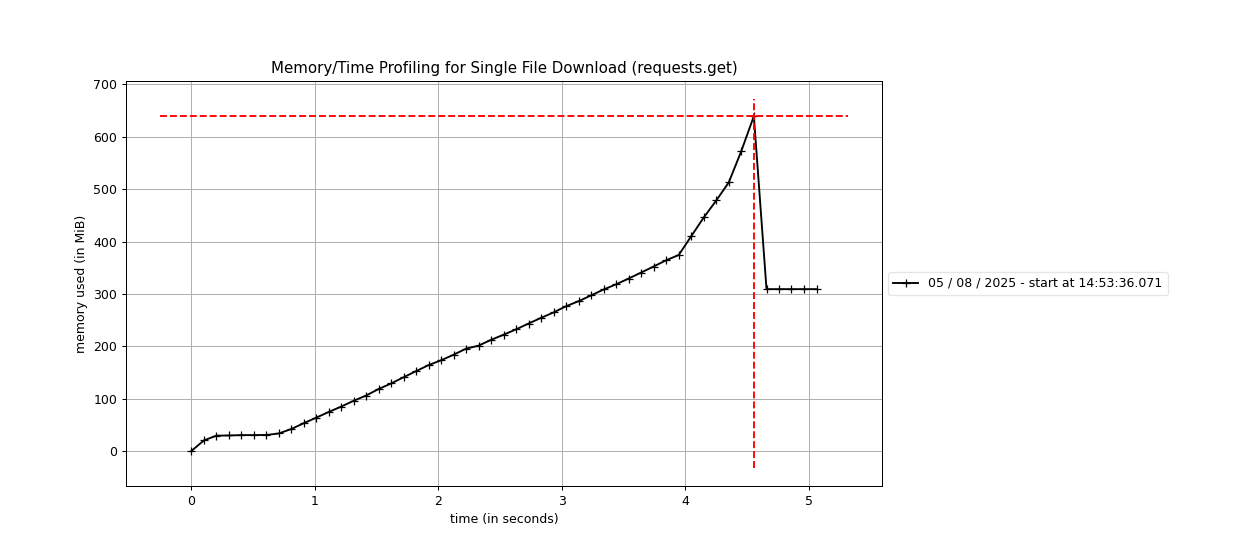

In [ ]:
from IPython.display import Image
Image('lean_requests_full.png')

under the hood requests:

* Opens the TCP connection and starts reading the response body in small chunks (internally via iter_content).

* Accumulates each chunk into a growing bytearray buffer in memory.

* Once the download finishes, converts that bytearray into an immutable bytes object to satisfy resp.content.

* Because of that two-step buffering you see in the profiler:

  Linear rise from 0 MiB up to ~350 MiB (≈ the 278 MiB ZIP plus overhead) as chunks get appended.

  A sudden spike to ~~640 MiB when converting the bytearray → bytes (both co-exist briefly).

  A drop back to ~310 MiB once the intermediate buffer is freed, leaving only the final bytes object.

Because you’re downloading the entire 278 MiB file into RAM, peak memory usage exceeds the file size (and even doubles briefly). This is un-optimized for large files: you end up holding the whole payload in memory.

In [ ]:
cost_1_TB = 0.0000166667/640 * 1000 * 1000 * 5
print(f"Cost of 1 TB unoptimized download: $ {cost_1_TB:.2f} ")

Cost of 1 TB unoptimized download: $ 0.13 


In [ ]:
1000000/640

1562.5

### Optimization of a single file download

since we got status code 200, we can keep going with our approach. Let's download a file.  

Since we are going to use AWS lambdas to download the files, we won't use requests module - it is not part of the standard AWS Linux 2 and would require a docker image or a layer.  

The simplest way is to use http.client - http is a default module included into AWS Linux 2.  

Let's download a sample file and do memory profiling:

In [ ]:
import subprocess
import os
import glob

# Step 1: Write the download script
with open("download_http.py", "w") as f:
    f.write('''import http.client
import time

HOST     = "coast.noaa.gov"
PATH     = "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip"
FILENAME = "AIS_2024_01_02.zip"
CHUNK    = 8192

start_time = time.time()

conn = http.client.HTTPSConnection(HOST)
conn.request("GET", PATH)
resp = conn.getresponse()

with open(FILENAME, "wb") as f:
    while True:
        chunk = resp.read(CHUNK)
        if not chunk:
            break
        f.write(chunk)

conn.close()

end_time = time.time()
download_time = end_time - start_time
print(f"Download time: {download_time:.2f} seconds")
''')

# Step 2: Run mprof profiling
subprocess.run(["mprof", "run", "--include-children", "python3", "download_http.py"], check=True)

# Step 3: Generate PNG from profiling data
subprocess.run(["mprof", "plot", "-o", "lean_http.png", "--title", "Memory/Time Profiling for Single File Download (http.client)"], check=True)

# Step 4: Parse download_time from download_http.py output (run again to capture stdout)
download_time = None
try:
    result = subprocess.run(["python3", "download_http.py"], capture_output=True, text=True, check=True)
    for line in result.stdout.splitlines():
        if "Download time:" in line:
            download_time = float(line.split(":")[1].strip().split()[0])
            break
except subprocess.CalledProcessError as e:
    print("Failed to run download script:", e)

# Step 5: Read max memory usage from latest mprofile_*.dat
def get_max_memory_from_mprof(filename_pattern):
    files = glob.glob(filename_pattern)
    if not files:
        print(f"No file matching pattern: {filename_pattern}")
        return None
    latest_file = max(files, key=os.path.getctime)
    print(f"Reading file: {latest_file}")
    max_mem = 0
    try:
        with open(latest_file, 'r') as f:
            for line in f:
                if line.startswith("MEM"):
                    parts = line.split()
                    memory = float(parts[1])
                    max_mem = max(max_mem, memory)
    except Exception as e:
        print(f"Error reading file {latest_file}: {e}")
        return None
    return max_mem

max_mem = get_max_memory_from_mprof("mprofile_*.dat")

# Step 6: Report results
if download_time is not None:
    print(f"✅ Download time: {download_time:.2f} seconds")
if max_mem is not None:
    print(f"📈 Max memory used: {max_mem:.2f} MiB")


Reading file: mprofile_20250805144501.dat
✅ Download time: 5.89 seconds
📈 Max memory used: 20.02 MiB


In [ ]:
cost_1_TB = 0.0000166667 / 1000 * 20.02 * 1000  * 5.89
print(f"Cost of 1 TB optimized download: $ {cost_1_TB:.4f} ")

Cost of 1 TB optimized download: $ 0.0020 


### Memory and Time Profiling: Single File Download with `http.client`

This chart shows the memory and time profile for downloading a single file using Python’s built-in `http.client` module.

- **Black Line**: Represents the memory usage of the main Python process and its child processes over time. This is possible because the script was run with the `--include-children` flag using `mprof run`.

- **Red Line** : Indicates the memory usage attributed specifically to child processes, helping isolate their memory footprint from the main process.

- **Scope**: The memory profile reflects only the memory used by the download script itself. It does **not** represent the total system memory usage.

- **Colab Context**: Google Colab notebooks typically consume **over 1 GB** of system memory even when idle, due to the overhead from the notebook interface, kernel, and browser environment.

- **Download Time Note**: The reported download time depends primarily on the **speed of the remote server** (in this case, NOAA) and the **network connection** between the server and the Colab VM. It may vary significantly based on external bandwidth and server load.



To check the **total virtual machine (VM) memory usage** in Colab, click the **downward arrow** next to **"RAM / Disk"** in the top-right corner of the notebook interface. Then select **"View resources"** to see real-time metrics for RAM, disk usage, and active sessions.


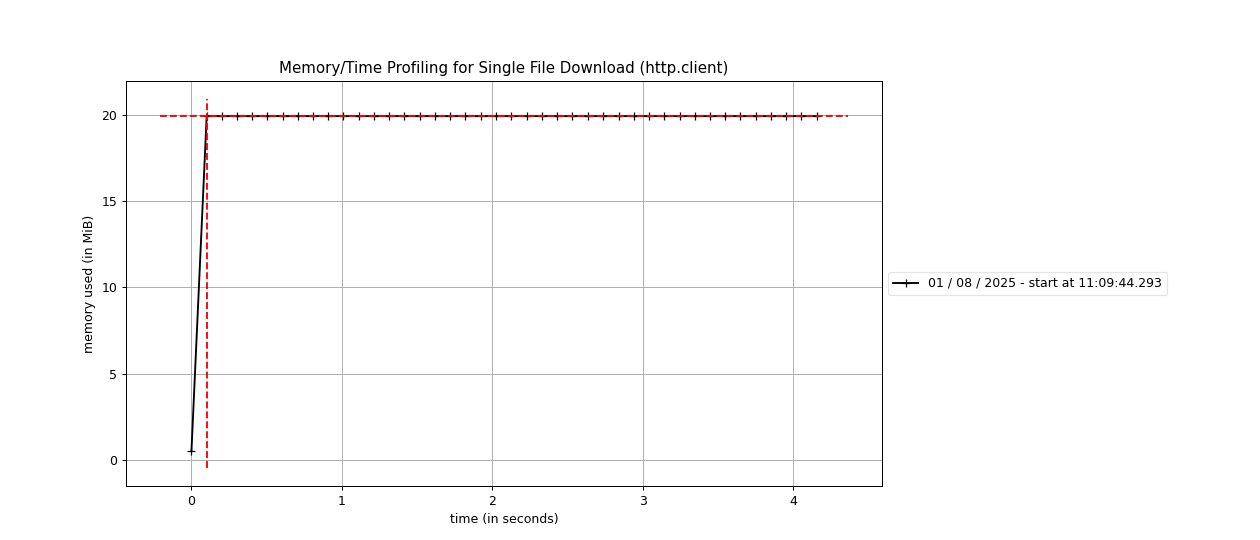

In [ ]:
from IPython.display import Image
Image('lean_http.png')

### Main Factors That Determine Download Time

- **Server throughput and load**: How fast NOAA’s servers can read from disk, process and stream the ZIP file. Under heavy load, response times can spike.

- **Network path characteristics**: Bandwidth, latency, and packet loss between the Colab VM (which itself may be in a particular Google datacenter region) and the NOAA server. Internet congestion, routing changes, and peering can all introduce variability.

- **Protocol overhead**: DNS resolution time, TCP handshake (and window-size negotiation), TLS handshake if HTTPS, and any HTTP redirects—all add a small but sometimes measurable delay.

- **Client-side factors**: CPU time spent in Python’s I/O loop and writing to disk (especially if you’re also profiling memory), the buffer (chunk) size you choose, and any garbage-collection pauses can slightly affect the wall-clock time.

- **Repetition and caching effects**: Subsequent downloads may hit caches (in Cloudflare, DNS resolvers, or the server itself) and be faster; first-run TLS certificates might also be cached.


# Raw Data ingestion - Multiple Files

In part one we discovered that it takes approximately 20 Mb of memory to downlaod 280 Mb file from the Vessel Traffic dataset. Of course, AWS lambda environment is very different from that of Colab, but we can use 20 Mb as a rough indication of the amount of memory we'll need when running the code as a lambda.

Given that lambda's system memory with Python runtime is ~35 Mb (You can check this by creating and running a lammbda without importing any libraries), there is enough gap between 128 Mb of available memory and 35 + 20 = 55 Mb.

Such a gap allow us to find ways to use more lambda's memory (we are paying for 128 Mb anyways) to further increase data throughput.  

The simplest thing to do is to implement asynchroneous data ingestion. With this approach we will be downloading several files at the same time using aiohttp

In [ ]:
!pip install -q aiohttp memory_profiler

In [ ]:
import asyncio
import aiohttp
import os
from datetime import datetime, timedelta

In [ ]:
%%bash

# 2) Save this as download_http_async.py
cat > download_http_async.py << 'EOF'
import asyncio
import aiohttp
import os

# === configure these ===
HOST   = "coast.noaa.gov"
PATHS  = [
    "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip",
    "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_03.zip",
    "/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_04.zip",
    # …add as many as you like…
]
CHUNK_SIZE   = 1024 * 8
CONCURRENCY  = 5      # max simultaneous downloads
OUTPUT_DIR   = "downloads"
# ======================

os.makedirs(OUTPUT_DIR, exist_ok=True)

async def download_one(session: aiohttp.ClientSession, path: str, sem: asyncio.Semaphore):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(path))
    url = f"https://{HOST}{path}"
    async with sem:
        async with session.get(url) as resp:
            resp.raise_for_status()
            with open(filename, "wb") as f:
                async for chunk in resp.content.iter_chunked(CHUNK_SIZE):
                    f.write(chunk)
    print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    timeout = aiohttp.ClientTimeout(total=None)  # or tune per-request timeouts
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [download_one(session, p, sem) for p in PATHS]
        # gather will run them all, but only CONCURRENCY at once
        await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# 3) Profile memory usage exactly as before
mprof run --include-children python3 download_http_async.py

# 4) Plot
mprof plot -o lean_async_http.png


✔ downloaded downloads/AIS_2024_01_03.zip
✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_02.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


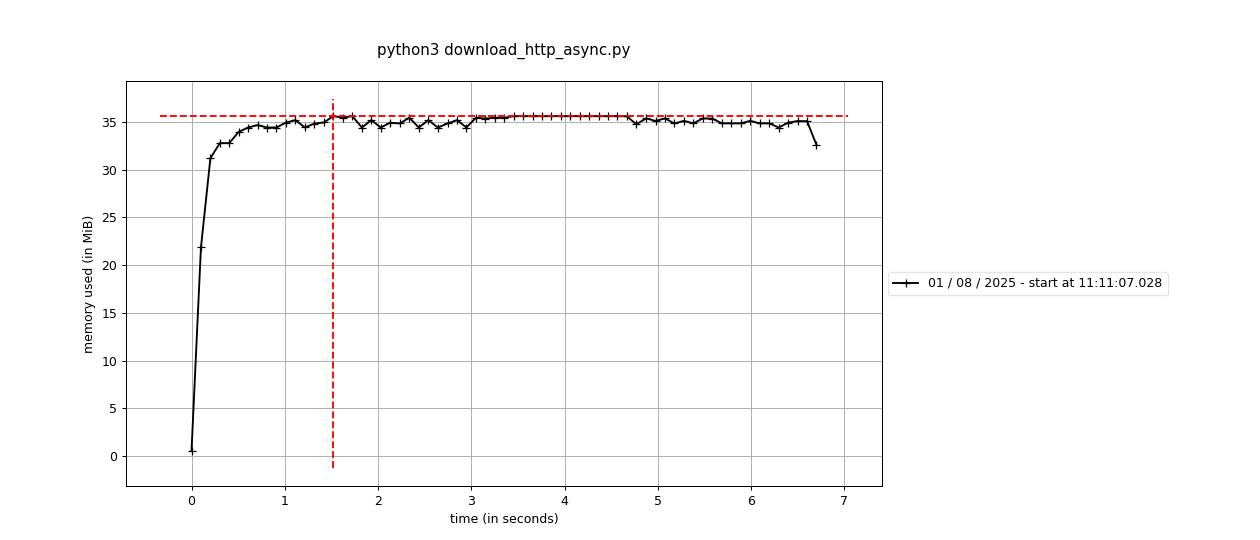

In [ ]:
from IPython.display import Image, display

# load by filename
img = Image(filename="lean_async_http.png")
display(img)

the memory profiling chart above shows that memory consumption peaked at ~ 36 Mb. It means that with 2 additional files we consumed (36 - 21)  15 Mb of memory, or 7.5 Mb per each additional file.  

This makes it possible to add even more files.

In [ ]:
from datetime import datetime, timedelta

In [ ]:
HOST         = "coast.noaa.gov"
START_DATE   = datetime(2024, 1, 2)
NUM_DAYS     = 10
YEAR         = START_DATE.year
CHUNK_SIZE   = 1024 * 8
CONCURRENCY  = 10
OUTPUT_DIR   = "downloads"

PATHS = [
    f"/htdata/CMSP/AISDataHandler/{YEAR}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
PATHS

['/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_02.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_03.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_04.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_05.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_06.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_07.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_08.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_09.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_10.zip',
 '/htdata/CMSP/AISDataHandler/2024/AIS_2024_01_11.zip']

In [ ]:
%%bash
# 1) Install aiohttp and memory_profiler
# pip install -q aiohttp memory_profiler

# 2) Write the async downloader as a script
cat > download_http_async.py << 'EOF'
import asyncio
import aiohttp
import os
from datetime import datetime, timedelta

# === configure these ===
HOST        = "coast.noaa.gov"
START_DATE  = datetime(2024, 1, 2)
NUM_DAYS    = 10
YEAR        = START_DATE.year
CHUNK_SIZE  = 1024 * 8
CONCURRENCY = 5
OUTPUT_DIR  = "downloads"

# generate N days of AIS files
PATHS = [
    f"/htdata/CMSP/AISDataHandler/{YEAR}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]
# ======================

os.makedirs(OUTPUT_DIR, exist_ok=True)

async def download_one(session, path, sem):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(path))
    url = f"https://{HOST}{path}"
    async with sem:
        async with session.get(url) as resp:
            resp.raise_for_status()
            with open(filename, "wb") as f:
                async for chunk in resp.content.iter_chunked(CHUNK_SIZE):
                    f.write(chunk)
    print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    timeout = aiohttp.ClientTimeout(total=None)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [download_one(session, p, sem) for p in PATHS]
        await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# 3) Profile memory usage
mprof run --include-children python3 download_http_async.py

# 4) Generate the plot
mprof plot -o lean_async_10_http.png


✔ downloaded downloads/AIS_2024_01_06.zip
✔ downloaded downloads/AIS_2024_01_05.zip
✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_03.zip
✔ downloaded downloads/AIS_2024_01_02.zip
✔ downloaded downloads/AIS_2024_01_10.zip
✔ downloaded downloads/AIS_2024_01_09.zip
✔ downloaded downloads/AIS_2024_01_11.zip
✔ downloaded downloads/AIS_2024_01_07.zip
✔ downloaded downloads/AIS_2024_01_08.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


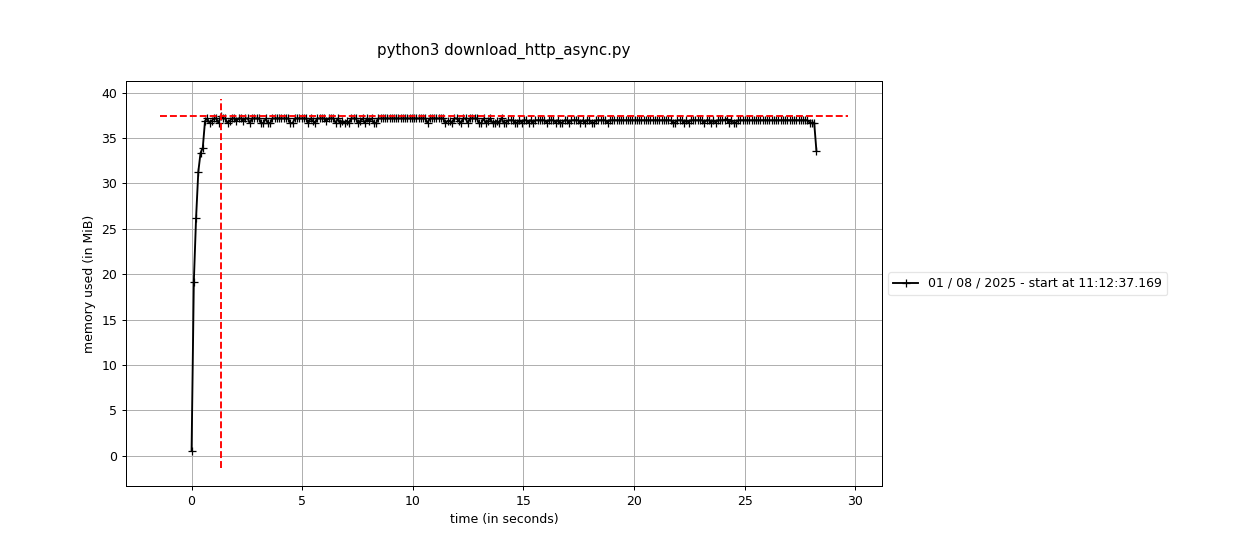

In [ ]:
img = Image(filename="lean_async_10_http.png")
display(img)

# parallel with wget

In [ ]:
%%bash

# Write Python code into download_http_async.py
cat > download_http_async.py << 'EOF'
import asyncio
import os
from datetime import datetime, timedelta

# === config ===
START_DATE   = datetime(2024, 1, 2)
NUM_DAYS     = 10
CONCURRENCY  = 5
HOST         = "https://coast.noaa.gov"
BASE_PATH    = "/htdata/CMSP/AISDataHandler/2024"
OUTPUT_DIR   = "downloads"
# ==============

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Generate the list of URLs
URLS = [
    f"{HOST}{BASE_PATH}/AIS_{(START_DATE + timedelta(days=i)).strftime('%Y_%m_%d')}.zip"
    for i in range(NUM_DAYS)
]

async def download_with_wget(url: str, sem: asyncio.Semaphore):
    filename = os.path.join(OUTPUT_DIR, os.path.basename(url))
    async with sem:
        process = await asyncio.create_subprocess_exec(
            'wget', url,
            '-O', filename,
            '--quiet',
            '--show-progress',
            '--no-verbose'
        )
        await process.communicate()
        print(f"✔ downloaded {filename}")

async def main():
    sem = asyncio.Semaphore(CONCURRENCY)
    tasks = [download_with_wget(url, sem) for url in URLS]
    await asyncio.gather(*tasks)

if __name__ == "__main__":
    asyncio.run(main())
EOF

# Now run the profiler
mprof run --include-children python3 download_http_async.py
mprof plot -o wget_async_plot.png


✔ downloaded downloads/AIS_2024_01_04.zip
✔ downloaded downloads/AIS_2024_01_03.zip
✔ downloaded downloads/AIS_2024_01_02.zip
✔ downloaded downloads/AIS_2024_01_06.zip
✔ downloaded downloads/AIS_2024_01_05.zip
✔ downloaded downloads/AIS_2024_01_11.zip
✔ downloaded downloads/AIS_2024_01_09.zip
✔ downloaded downloads/AIS_2024_01_10.zip
✔ downloaded downloads/AIS_2024_01_08.zip
✔ downloaded downloads/AIS_2024_01_07.zip
mprof: Sampling memory every 0.1s
running new process
Using last profile data.


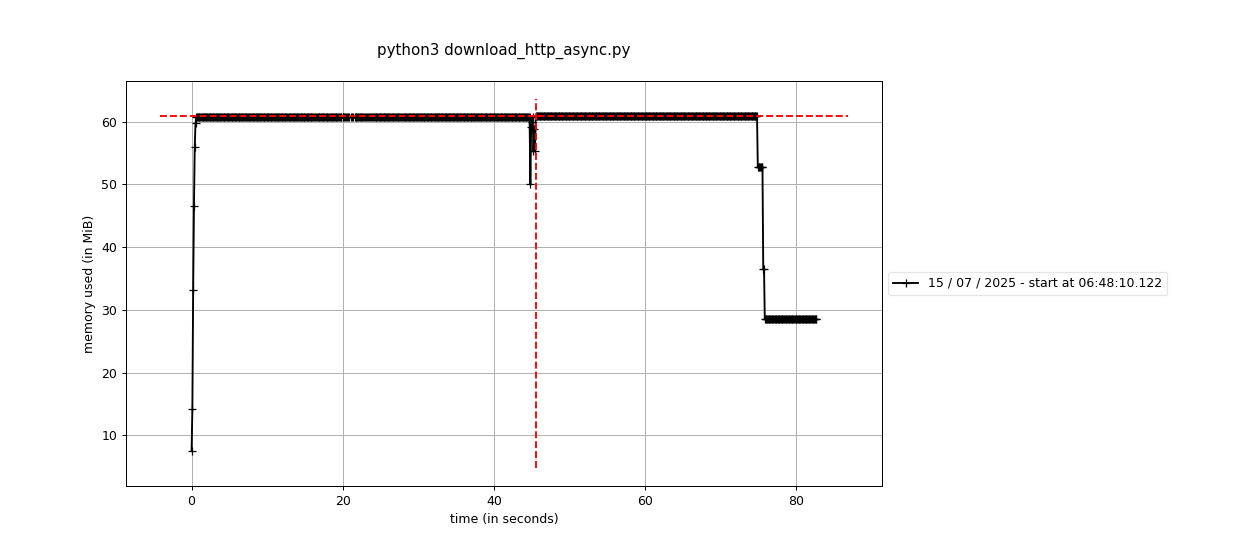

In [ ]:
img = Image(filename="wget_async_plot.png")
display(img)

Add your comment about the chart here.

This chart shows the memory and time profile for downloading a single file using `http.client`. The black line indicates the total memory usage, which is relatively stable throughout the download, stabilizing at approximately 21 MiB. The red line shows the memory usage of the child process (the Python script itself). The x-axis represents time, and the y-axis represents memory usage in MiB. The download time for this file was 7.40 seconds. The maximum memory utilized was {max_mem:.2f} MiB. The profile shows that this method is memory-efficient for downloading a single file.